## Building Basic Neural Networks in PyTorch 

To implement our own Neural networks in PyTorch, we build a class inheriting form `nn.Module` and use other `nn.Module`s to define our own Neural Network, since most basic Layers, such as Linear, Convolution, Attention or RNN based ones, are already implemented in PyTorch. Similarly, we can also define our own Layers and reuse them in other Modules. 

The class `nn.Module` offers basic functionaility and expects us only to implement the forward pass in `model.forward()`.

Other than that, it also gives us things like `model.state_dict()` which is returns all the Parameters of our Model layer wise as a dictionary. 

We get much more functionaility, which we will get into later. For now, lets see how we can build a simple NN.

### Building a basic Neural Network | Two ways 

To build a basic MLP, we can just define every layer as a variable of our class, as we will see in the following first example. Another way to implement an MLP is to use `nn.Sequential` the latter is easier to use, as we don't need to implement the forward method ourselves, but of course this makes it less customizable. 

`nn.Sequential` is very similar to `nn.ModuleList`, however the latter is literally just a list as opposed to `nn.Sequential`.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class sampleNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.Layer1 = nn.Linear(1,5)
        self.act1 = nn.ReLU()
        self.Layer2 = nn.Linear(5,3)
        self.act2 = nn.Tanh()
        self.Layer3 = nn.Linear(3,3)
        self.act3 = nn.ReLU()
        self.Layer4 = nn.Linear(3,1)
        
    def forward(self, x):
        x = self.Layer1(x)
        x = self.act1(x)
        x = self.Layer2(x)
        x = self.act2(x)
        x = self.Layer3(x)
        x = self.act3(x)
        x = self.Layer4(x)
        return x
    
# The same as the above Neural Network we can implement using the Sequential class as follows

model1 = sampleNN()

model2 = nn.Sequential(
    nn.Linear(1,5),
    nn.ReLU(),
    nn.Linear(5,3),
    nn.Tanh(),
    nn.Linear(3,3),
    nn.Tanh(),
    nn.Linear(3,1)
)
print(model1.state_dict())
print(model2.state_dict())

OrderedDict({'Layer1.weight': tensor([[ 0.5829],
        [-0.6729],
        [-0.5678],
        [ 0.4775],
        [-0.1380]]), 'Layer1.bias': tensor([-0.9716,  0.1463, -0.6795,  0.4006, -0.9935]), 'Layer2.weight': tensor([[-0.0649,  0.3667, -0.2898, -0.1087,  0.0762],
        [-0.1426, -0.4036, -0.4268, -0.2323, -0.4046],
        [-0.3658, -0.2015, -0.1345, -0.1961, -0.0245]]), 'Layer2.bias': tensor([0.0800, 0.1327, 0.0495]), 'Layer3.weight': tensor([[-0.4646, -0.1953, -0.0624],
        [ 0.0293, -0.0225, -0.3419],
        [ 0.1632,  0.3884,  0.2142]]), 'Layer3.bias': tensor([0.2076, 0.5362, 0.0436]), 'Layer4.weight': tensor([[ 0.3036,  0.4364, -0.3376]]), 'Layer4.bias': tensor([-0.0371])})
OrderedDict({'0.weight': tensor([[-0.9087],
        [-0.2402],
        [ 0.8786],
        [-0.6718],
        [ 0.9514]]), '0.bias': tensor([ 0.8037, -0.5372, -0.2430, -0.5394,  0.6473]), '2.weight': tensor([[-0.2953,  0.3972, -0.3586, -0.2282, -0.0775],
        [ 0.0652,  0.0932, -0.1148, -0.1189, -

In [3]:
for p in model1.parameters():
    print(p)

Parameter containing:
tensor([[ 0.5829],
        [-0.6729],
        [-0.5678],
        [ 0.4775],
        [-0.1380]], requires_grad=True)
Parameter containing:
tensor([-0.9716,  0.1463, -0.6795,  0.4006, -0.9935], requires_grad=True)
Parameter containing:
tensor([[-0.0649,  0.3667, -0.2898, -0.1087,  0.0762],
        [-0.1426, -0.4036, -0.4268, -0.2323, -0.4046],
        [-0.3658, -0.2015, -0.1345, -0.1961, -0.0245]], requires_grad=True)
Parameter containing:
tensor([0.0800, 0.1327, 0.0495], requires_grad=True)
Parameter containing:
tensor([[-0.4646, -0.1953, -0.0624],
        [ 0.0293, -0.0225, -0.3419],
        [ 0.1632,  0.3884,  0.2142]], requires_grad=True)
Parameter containing:
tensor([0.2076, 0.5362, 0.0436], requires_grad=True)
Parameter containing:
tensor([[ 0.3036,  0.4364, -0.3376]], requires_grad=True)
Parameter containing:
tensor([-0.0371], requires_grad=True)


#### Model Parameters in Neural Networks

As we can see, all layers are automatically associated as a Model Parameter that we want to optimize for (since `requires_grad = True`), but this is sometimes not desired (for example, the hidden state for Recurrent Neural Networks serves as "memory" and is not something we want to optimize for). Gnerally, if we want a Tensor to be a Parameters, we define it via `nn.Parameter(Tensor)` if we dont want it to be a Parameter, we just define it as a Tensor. Using `detach()` we can also change any Parameter into a non-Parameter. 

If we don't want to optimize for something, we can also set `requires_grad = False`.  Here is a Table that shows the difference between the two. 

| **Aspect**                 | **`requires_grad=False`**                      | **Not a Parameter**                          |
|----------------------------|-----------------------------------------------|---------------------------------------------|
| **Tracked by `state_dict`** | Yes                                           | No                                          |
| **Included in optimization** | No                                           | No                                          |
| **Can be saved/loaded**     | Yes                                           | No                                          |
| **Gradients computed**      | No                                           | Not applicable (not part of the graph)     |
| **Use case**                | Temporarily freeze training for specific parameters. | Variables/constants that are not trainable or part of the model's state. |

For RNN it is typical to not have it as a Parameter. 

Lets see how the usual training loop of basic NNs looks like by training a Neural Network to approximate a sine wave.

In [4]:
#get data 
n = 300
#get sinuoidal data
data = torch.sin(torch.linspace(0, 4*3.1415, n)).view(-1,1)

lossfunction = nn.L1Loss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)

for epoch in range(20000):
    model1.zero_grad()
    y = model1(data)
    loss = lossfunction(y, data)
    loss.backward()        
    optimizer.step()
    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

Epoch: 0, Loss: 0.6403626799583435
Epoch: 1000, Loss: 0.016202056780457497
Epoch: 2000, Loss: 0.0036818564403802156
Epoch: 3000, Loss: 0.012518495321273804
Epoch: 4000, Loss: 0.012717857956886292
Epoch: 5000, Loss: 0.009220829233527184
Epoch: 6000, Loss: 0.00692359684035182
Epoch: 7000, Loss: 0.0036844094283878803
Epoch: 8000, Loss: 0.0075304326601326466
Epoch: 9000, Loss: 0.002185889519751072
Epoch: 10000, Loss: 0.003990953788161278
Epoch: 11000, Loss: 0.012007325887680054
Epoch: 12000, Loss: 0.004866347182542086
Epoch: 13000, Loss: 0.002924861153587699
Epoch: 14000, Loss: 0.004161527380347252
Epoch: 15000, Loss: 0.009264785796403885
Epoch: 16000, Loss: 0.012205657549202442
Epoch: 17000, Loss: 0.004945901222527027
Epoch: 18000, Loss: 0.00394162954762578
Epoch: 19000, Loss: 0.01265063975006342


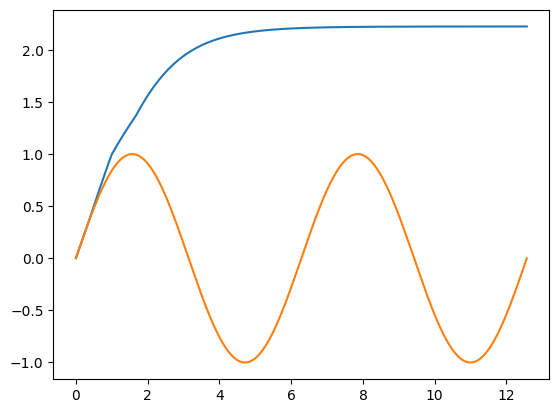

In [5]:
test = torch.linspace(0*3.1415,4*3.1415, n)
output = torch.zeros(n)

for i in range(n):
    output[i] = model1(test[i].view(-1,1))
    
test = test.detach().numpy()

plt.plot(test, output.detach().numpy())   
plt.plot(test, np.sin(test))
plt.show()
#Oh no it seems our Model is lacking in expressivity, what could we improve?